### IMDB

In [29]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter


import spacy
import en_core_web_sm
from spacy import displacy
from spacy.util import minibatch, compounding
import scattertext as st
import re,string,unicodedata
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost.sklearn import XGBClassifier

In [2]:
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

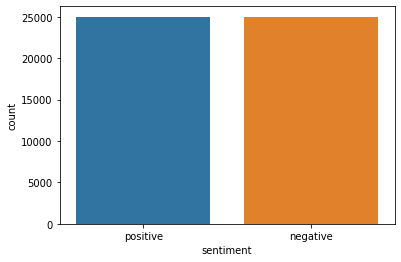

In [4]:
sns.countplot(data['sentiment'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Sentiment Part

In [7]:
# convert to numerical
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

### Review Part

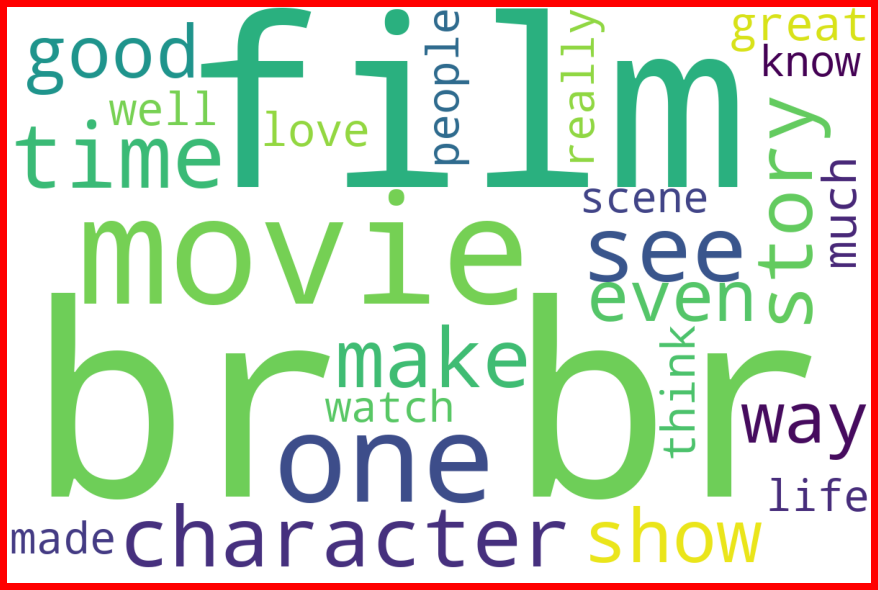

In [8]:
## wordcloud for positive review
positive=data['review'][data['sentiment']==1]
spamcloud=WordCloud(width=1200,height=800,background_color='white',max_words=25).generate(' '.join(positive))

plt.figure(figsize=(12,8),facecolor='r')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

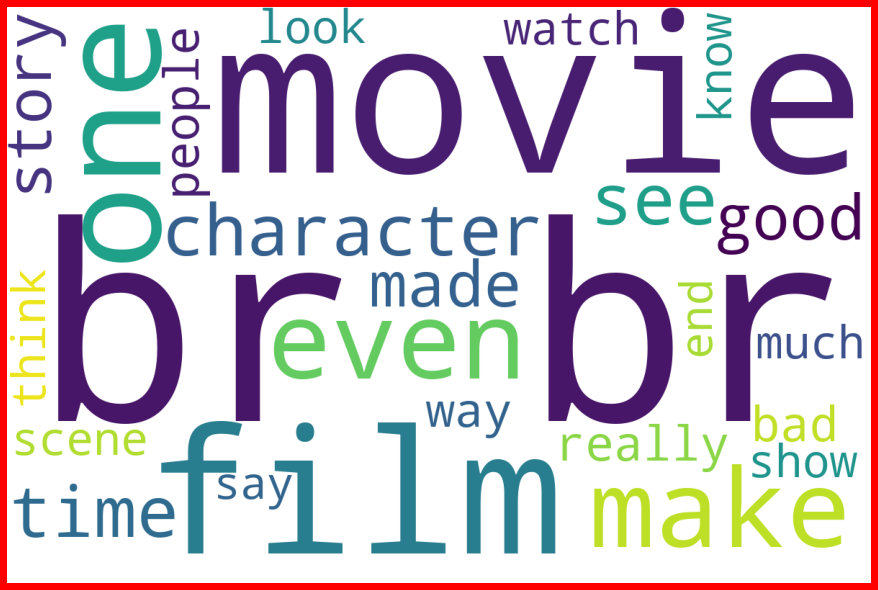

In [9]:
## wordcloud for negative review
positive=data['review'][data['sentiment']==0]
spamcloud=WordCloud(width=1200,height=800,background_color='white',max_words=25).generate(' '.join(positive))

plt.figure(figsize=(12,8),facecolor='r')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [10]:
## remove some unnecessary words such as br from wordcloud we see
# REMOVE UNNECESSARY WORDS FROM DESCRIPTION
data['review'] = data['review'].apply(lambda x: x.replace("<br />", ""))
data['review'] = data['review'].apply(lambda x: x.replace("br", ""))
data['review'] = data['review'].apply(lambda x: x.replace("<p><a", ""))

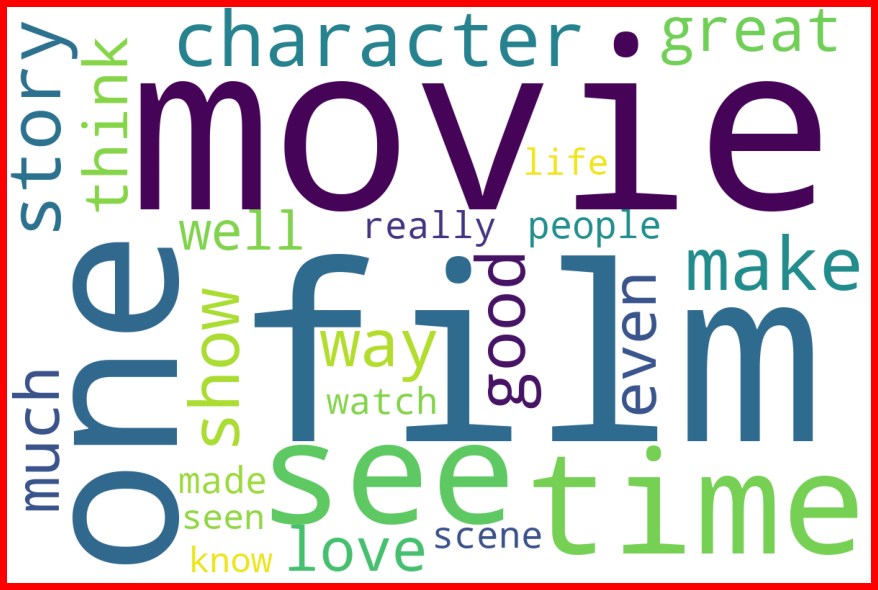

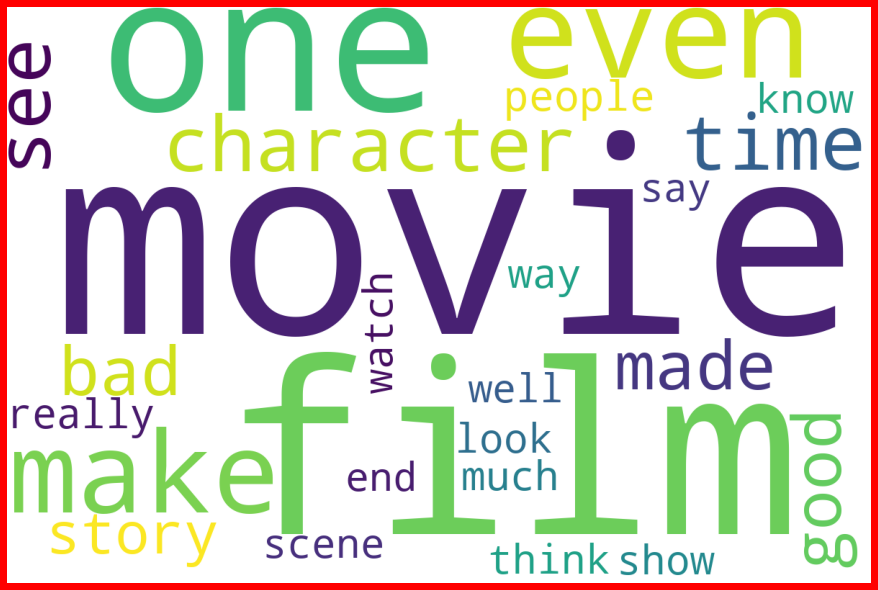

In [11]:
# AFTER REMOVING THESE WORDS CHECK AGAIN
positive=data['review'][data['sentiment']==1]
spamcloud=WordCloud(width=1200,height=800,background_color='white',max_words=25).generate(' '.join(positive))

plt.figure(figsize=(12,8),facecolor='r')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

negative=data['review'][data['sentiment']==0]
spamcloud=WordCloud(width=1200,height=800,background_color='white',max_words=25).generate(' '.join(negative))

plt.figure(figsize=(12,8),facecolor='r')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [12]:
# check duplicate
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 419 duplicate reviews present in the dataset


In [13]:
# drop duplicate rows
data.drop_duplicates(inplace = True)

In [14]:
# check duplicate again
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 0 duplicate reviews present in the dataset


In [15]:
# check unnecessary part of reviews, Find if exists and count
re_urls = r'http\S+'
re_html = r'<.*?>'
re_mentions = r'@\w+' 
re_hastags = r'#\w+'
re_digits = r'\d+'
re_punc = r'[^\w\s\d]'

print("Number of urls in reviews ", data['review'].str.count(re_urls).sum())
print("Number of html tag in reviews ", data['review'].str.count(re_html).sum())
print("Number of mentions in reviews ", data['review'].str.count(re_mentions).sum())
print("Number of hastags in reviews ", data['review'].str.count(re_hastags).sum())
print("Number of digits in reviews ", data['review'].str.count(re_digits).sum())
print("Number of digits in reviews ", data['review'].str.count(re_punc).sum())

Number of urls in reviews  128
Number of html tag in reviews  36
Number of mentions in reviews  93
Number of hastags in reviews  431
Number of digits in reviews  77714
Number of digits in reviews  2010994


In [16]:
# unnecessary tags
re_tag = '&amp'

sum_tag = data['review'].str.contains(re_tag).sum()
print("Before sum : ", sum_tag)

Before sum :  0


In [17]:
# remove unnecessary words that cannot effect classification
def remove_words(text):
    #remove urls
    text = re.sub(re_urls, '', text)
    #remove html
    text = re.sub(re_html, '', text)
    #remove mentions
    text = re.sub(re_mentions,'',text)
    #remove hastags
    text = re.sub(re_hastags, '', text)
    #remove digits
    text = re.sub(re_digits, '', text)
    #remove punctuaions
    text = re.sub(re_punc, '', text)
    
    return text

data['review'] = data['review'].apply(lambda x: remove_words(x))

In [18]:
# check again unnecessary part of reviews, Find if exists and count
re_urls = r'http\S+'
re_html = r'<.*?>'
re_mentions = r'@\w+' 
re_hastags = r'#\w+'
re_digits = r'\d+'
re_punc = r'[^\w\s\d]'

print("Number of urls in reviews ", data['review'].str.count(re_urls).sum())
print("Number of html tag in reviews ", data['review'].str.count(re_html).sum())
print("Number of mentions in reviews ", data['review'].str.count(re_mentions).sum())
print("Number of hastags in reviews ", data['review'].str.count(re_hastags).sum())
print("Number of digits in reviews ", data['review'].str.count(re_digits).sum())
print("Number of digits in reviews ", data['review'].str.count(re_punc).sum())

Number of urls in reviews  0
Number of html tag in reviews  0
Number of mentions in reviews  0
Number of hastags in reviews  0
Number of digits in reviews  0
Number of digits in reviews  0


In [19]:
#Converting into lower case
data['review']=data['review'].str.lower()

In [20]:
# stop words cleaning
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    word_tokens = word_tokenize(text)
 
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]

    filtered_text = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_text.append(w)
            
    return " ".join(filtered_text)
    
data['review'] = data['review'].apply(lambda x: remove_stop_words(x))

### SENTIMENT CONTINUE

In [21]:
# CHECK COMMON WORDS ON EACH SENTIMENT
positive = Counter(" ".join(data[data['sentiment']== 1]['review']).split()).most_common()
negative = Counter(" ".join(data[data['sentiment']== 0]['review']).split()).most_common()

<AxesSubplot:title={'center':'POSITIVE SENTIMENT COMMON WORDS'}>

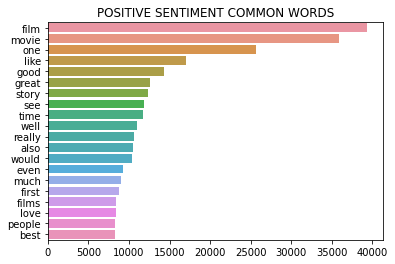

In [22]:
positive_words = [item[0] for item in positive]
positive_counts = [item[1] for item in positive]

plt.title("POSITIVE SENTIMENT COMMON WORDS")
sns.barplot(x=positive_counts[:20], y=positive_words[:20])

<AxesSubplot:title={'center':'NEGATIVE SENTIMENT COMMON WORDS'}>

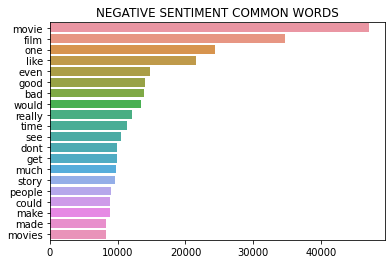

In [23]:
negative_words = [item[0] for item in negative]
negative_counts = [item[1] for item in negative]

plt.title("NEGATIVE SENTIMENT COMMON WORDS")
sns.barplot(x=negative_counts[:20], y=negative_words[:20])

### BASIC MODELS OF ML

In [41]:
#splitting into train and test
X = data.drop(['sentiment'], axis = 1)
y = data.sentiment

train, test= train_test_split(data, test_size=0.3, random_state=4)
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']

In [42]:
#Vectorizing data

tfidf_vect = TfidfVectorizer() #tfidfVectorizer
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)


count_vect = CountVectorizer() # CountVectorizer
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

[21:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :  0.8700504201680672


C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


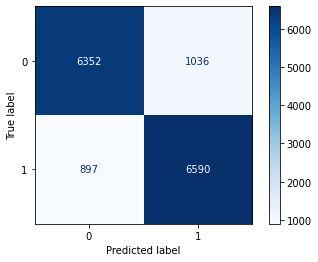

In [44]:
### XGBOOST
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth = 10)
xgb_model.fit(X_train_tfidf, y_train)
xgb_pred = xgb_model.predict(X_test_tfidf)
print("Accuracy : ", accuracy_score(y_test, xgb_pred.round()))
plot_confusion_matrix(xgb_model, X_test_tfidf, y_test, cmap = 'Blues')
plt.grid(False)